Start by importing a load of stuff

Add to this later if need more packages

In [2]:
import sympy as sym
sym.init_printing()

import numpy as np
from math import pi

import matplotlib.pyplot as plt
from sympy import I, Matrix, symbols
from sympy.physics.quantum import TensorProduct, Dagger
import scipy.optimize
import scipy.integrate

import scipy.constants as const

#import qutip

from matplotlib.colors import Normalize as Norm

%load_ext cython

In [3]:
#define some s pre/post operators
#used for defining superoperators like L in matrix form

def spre(m):
    return TensorProduct(sym.eye(m.shape[0]),m)

def spost(m):
    return TensorProduct(m.T, sym.eye(m.shape[0]))

def collapse(c):
    tmp = Dagger(c)*c/2
    return spre(c)*spost(Dagger(c))-spre(tmp)-spost(tmp)


s13=Matrix([[0,0,1],[0,0,0],[0,0,0]])
s23=Matrix([[0,0,0],[0,0,1],[0,0,0]])
s12=Matrix([[0,1,0],[0,0,0],[0,0,0]])

s31=s13.T
s32=s23.T
s21=s12.T

s11 = s12*s21
s22 = s21*s12
s33 = s31*s13

In [4]:
#define symbols that are used for the symbolic stuff
delta2,delta3=sym.symbols('delta_2 delta_3', real=True)
gamma13,gamma23,gamma2d,gamma3d,nbath,gammamu=sym.symbols('gamma_13 gamma_23 gamma_2d gamma_3d n_b gamma_mu', real=True, negative=False)
omegao, omegam=sym.symbols('Omega_o Omega_mu', real=True, negative=False)
rho11, rho12, rho13, rho21, rho22, rho23, rho31, rho32, rho33=sym.symbols('rho_11 rho_12 rho_13 rho_21 rho_22 rho_23 rho_31 rho_32 rho_33')

a= sym.symbols('a')
ar,ai=sym.symbols('a_r a_i', real=True)
g=sym.symbols('g',real=True, negative=False)
lam=sym.symbols('lambda')

In [5]:
#define the Hamiltonian for the system
#might add to this if we want to include more stuff
H=omegam*s21+omegao*s32+ g*a*s31
H=H+Dagger(H)
H=H+delta2*s22+delta3*s33

H_no_a=H[:,:]
H_no_a[0,2]=0
H_no_a[2,0]=0
H_no_a

H_o=H_no_a[:,:]
H_o[0,1]=0
H_o[1,0]=0

H_mu=H_no_a[:,:]
H_mu[2,1]=0
H_mu[1,2]=0


H, H_no_a, H_o, H_mu

⎛⎡            _⎤                                             ⎞
⎜⎢ 0   Ωₘᵤ  g⋅a⎥  ⎡ 0   Ωₘᵤ  0 ⎤  ⎡0  0   0 ⎤  ⎡ 0   Ωₘᵤ  0 ⎤⎟
⎜⎢             ⎥  ⎢            ⎥  ⎢         ⎥  ⎢            ⎥⎟
⎜⎢Ωₘᵤ  δ₂   Ωₒ ⎥, ⎢Ωₘᵤ  δ₂   Ωₒ⎥, ⎢0  δ₂  Ωₒ⎥, ⎢Ωₘᵤ  δ₂   0 ⎥⎟
⎜⎢             ⎥  ⎢            ⎥  ⎢         ⎥  ⎢            ⎥⎟
⎝⎣a⋅g  Ωₒ   δ₃ ⎦  ⎣ 0   Ωₒ   δ₃⎦  ⎣0  Ωₒ  δ₃⎦  ⎣ 0    0   δ₃⎦⎠

In [6]:
#define the Liovillian for the system in Matrix form
#We change the first row to impose the normalisation condition
LH=-I*spre(H)+I*spost(H)
L21 = gammamu*(nbath+1)*collapse(s12)
L12 = gammamu*nbath*collapse(s21)
L32 = gamma23*collapse(s23)
L31 = gamma13*collapse(s13)
L22 = gamma2d*collapse(s22)
L33 = gamma3d*collapse(s33)

L = LH + L21 + L12 + L32 + L31 + L22 + L33

#L = L.row_insert(0,Matrix([[1,0,0,0,1,0,0,0,1]]))
#L.row_del(1)

In [7]:
#define the density matrix in square and row form
#the row form is so the Liovillian in matrix form can be acted on it
rho = Matrix([[rho11,rho21,rho31],[rho12,rho22,rho32],[rho13,rho23,rho33]])
rho = 1*rho.T #because we are using "fortran" style matrix flatteneing
rho[:]
rhoflat = 1*rho.T 
rhoflat = rhoflat[:]

In [8]:
#CtoR takes the complex, Hermitian Liovillian and transforms to a real, non hermitian version
CtoR = Matrix([[2,0,0,0,0,0,0,0,0],
               [0,0,0,0,2,0,0,0,0],
               [0,0,0,0,0,0,0,0,2],
               [0,1,0,1,0,0,0,0,0],
               [0,I,0,-I,0,0,0,0,0],
               [0,0,1,0,0,0,1,0,0],
               [0,0,I,0,0,0,-I,0,0],
               [0,0,0,0,0,1,0,1,0],
               [0,0,0,0,0,I,0,-I,0]
              ])
CtoR=CtoR/2

In [9]:
#make lambda functions for the Liovillian so it can be used for numerics

Lreal = sym.simplify(CtoR*L*CtoR.inv())
Lreal = Lreal.subs(a,ar+I*ai)
Lreal


Lfunc = sym.lambdify((a,delta2, delta3, gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,omegao,omegam,g),L)

Lrealfunc = sym.lambdify((ar,ai,delta2, delta3, gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,omegao,omegam,g),Lreal)

In [58]:
aval=0.
gamma13val=1./22e-3
gamma23val=1./22e-3
gamma2dval=1./1e-6
gamma3dval=1./1e-6
nbathval=20
gammamuval=1./((nbathval+1)*11e-3)
omegaoval=1e3
omegamval=1e7
gval=0
p={}
p['gamma13'] = 1./22e-3
p['gamma23'] = 1./22e-3
p['gamma2d'] = 1./1e-6
p['gamma3d'] = 1./1e-6
p['nbath'] = 20
p['gammamu'] = 1./((p['nbath']+1)*11e-3)
p['omegao'] = 1e7
p['omegam'] = 1e3
p['g'] = 0.
m2val=0.
m3val=0.
sd2val=20e6/2.355
sd3val=300e6/2.355


ndelta2=51
ndelta3=51

aval=0
delta2_mean=0
delta3_mean=0
delta2_sd=10e6
delta3_sd=10e6
#delta2vals = np.linspace(-3,3,ndelta2)*sd2val+m2val
#delta3vals = np.linspace(-3,3,ndelta3)*sd3val+m3val
delta2vals=np.linspace(-40e6,40e6,ndelta2)
delta3vals=np.linspace(-40e6,40e6,ndelta3)
delta2_max=np.max(delta2vals)
delta2_min=np.min(delta2vals)
delta3_max=np.max(delta3vals)
delta3_min=np.min(delta3vals)
im_lims=[np.min(delta3vals), np.max(delta3vals),np.min(delta2vals), np.max(delta2vals)]

In [35]:
def dressed_states(delta3vals,p):
    omegamval=p['omegam']
    omegaoval=p['omegao']
    H_disc=sym.discriminant(sym.det(H_no_a-lam*sym.eye(3)),lam)
    H_disc_fun=sym.lambdify((delta2,delta3, omegam, omegao), H_disc)
    H_disc_diff=sym.diff(H_disc,delta2)
    H_disc_diff_fun=sym.lambdify((delta2,delta3, omegam, omegao), H_disc_diff)
    delta2_ds_vals=np.zeros(len(delta3vals))
    delta3min=np.min(delta3vals)
    delta3max=np.max(delta3vals)
    for ii in range(len(delta3vals)):
        try:
            delta2_ds_vals[ii]=scipy.optimize.brentq(H_disc_diff_fun,-(-omegamval**2/delta3vals[ii]+delta3vals[ii]), omegaoval**2/delta3vals[ii],
                                                 args=(delta3vals[ii], omegamval, omegaoval))
            #if np.abs(H_disc_fun(delta2_ds_vals[ii],delta3vals[ii], omegamval, omegaoval))>1e36:
             #   delta2_ds_vals[ii]=np.nan
        except (ValueError, RuntimeError) as e:
            try:
                delta2_ds_vals[ii]=scipy.optimize.brentq(H_disc_diff_fun,(-omegamval**2/delta3vals[ii]+delta3vals[ii]), -omegaoval**2/delta3vals[ii],
                                                 args=(delta3vals[ii], omegamval, omegaoval))
            except (ValueError, RuntimeError) as e:
                delta2_ds_vals[ii]=np.nan
    return delta2_ds_vals

In [36]:
def dressed_states_single(delta3val,p):
    omegamval=p['omegam']
    omegaoval=p['omegao']
    H_disc=sym.discriminant(sym.det(H_no_a-lam*sym.eye(3)),lam)
    H_disc_fun=sym.lambdify((delta2,delta3, omegam, omegao), H_disc)
    H_disc_diff=sym.diff(H_disc,delta2)
    H_disc_diff_fun=sym.lambdify((delta2,delta3, omegam, omegao), H_disc_diff)
    #delta2_ds_vals=np.zeros(len(delta3vals))
    #delta3min=np.min(delta3vals)
    #delta3max=np.max(delta3vals)
    try:
        delta2_ds_val=scipy.optimize.brentq(H_disc_diff_fun,-(-omegamval**2/delta3val+delta3val), omegaoval**2/delta3val,
                                                 args=(delta3val, omegamval, omegaoval))
            #if np.abs(H_disc_fun(delta2_ds_vals[ii],delta3vals[ii], omegamval, omegaoval))>1e36:
             #   delta2_ds_vals[ii]=np.nan
    except (ValueError, RuntimeError,ZeroDivisionError) as e:
        try:
            delta2_ds_val=scipy.optimize.brentq(H_disc_diff_fun,(-omegamval**2/delta3val+delta3val), -omegaoval**2/delta3val,
                                                 args=(delta3val, omegamval, omegaoval))
        except (ValueError, RuntimeError,ZeroDivisionError) as e:
                delta2_ds_val=np.nan
    return delta2_ds_val

In [32]:
def steady_rho_lots_of_args(a,delta2,delta3,gamma_13,gamma_23,gamma_2d,gamma_3d, n_b,gamma_mu,omegao,omegamu,g):
    a_r=np.real(a)
    a_i=np.imag(a)
    L_mat=Lfunc(a, delta2,delta3,gamma_13,gamma_23,gamma_2d,gamma_3d, n_b,gamma_mu,omegao,omegamu,g)
    rho = np.linalg.solve(L_mat.astype('complex128'),np.matrix([[1,0,0,0,0,0,0,0,0]]).T)
    return np.reshape(rho,(3,3),order='F')
def steady_rho_lots_of_args_inds(ind1,ind2,a,delta2vals,delta3vals,gamma_13,gamma_23,gamma_2d,gama_3d, n_b,gamma_mu,omegao,omegamu,g):
    coh_vals=np.zeros((len(delta2vals),len(delta3vals)), dtype=np.complex_)
    for ii in range(len(delta2vals)):
        for jj in range(len(delta3vals)):
            coh_vals[ii,jj]=steady_rho_lots_of_args(a,delta2vals[ii],delta3vals[jj],gamma_13,gamma_23,gamma_2d,gama_3d, n_b,gamma_mu,omegao,omegamu,g)[ind1-1,ind2-1]
    return coh_vals

In [63]:
def steady_rho_lots_of_args(delta2val,delta3val,aval,p):
    #L_mat=Lfunc(a, delta2,delta3,gamma_13,gamma_23,gamma_2d,gamma_3d, n_b,gamma_mu,omegao,omegamu,g)
    L_mat=Lfunc(aval, delta2val,delta3val,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'], p['nbath'],p['gammamu'],p['omegao'],p['omegam'],p['g'])

    rho = np.linalg.solve(L_mat.astype('complex128'),np.matrix([[1,0,0,0,0,0,0,0,0]]).T)
    return np.reshape(rho,(3,3),order='F')
def steady_rho_lots_of_args_inds(ind1,ind2,delta2vals, delta3vals,aval, p):
    coh_vals=np.zeros((len(delta2vals),len(delta3vals)), dtype=np.complex_)
    for ii in range(len(delta2vals)):
        for jj in range(len(delta3vals)):
            coh_vals[ii,jj]=steady_rho_lots_of_args(delta2vals[ii],delta3vals[jj],aval,p)[ind1-1,ind2-1]
    return coh_vals

In [64]:
#steady_rho_lots_of_args_inds(1,3,aval,delta2vals,delta3vals,gamma13val,gamma23val,gamma2dval,gamma3dval,nbathval,gammamuval,omegaoval, omegamval,gval)
steady_rho_lots_of_args_inds(1,3,delta2vals,delta3vals,1,p)

array([[-8.66979939e+08-8.10473311e+06j, -2.01414204e+08-4.93017160e+08j,
        -2.11314321e+08-1.90900258e+08j, ...,
         8.54955961e+04-3.39047761e+06j, -1.60193882e+03-2.90494969e+06j,
         6.59356642e+02+1.04545588e+07j],
       [ 1.85014089e+07+2.97155776e+08j,  7.55351863e+08+8.14263649e+06j,
        -1.50935921e+08-1.77511028e+08j, ...,
         8.96021877e+04-4.97933845e+06j, -2.43870406e+04+2.51405472e+06j,
         1.94750922e+04-4.55213749e+07j],
       [ 1.02434551e+08+3.61672896e+08j, -8.16963646e+07+2.55644254e+08j,
        -3.71351161e+08-9.94590780e+06j, ...,
        -2.73505366e+03-4.71170099e+07j, -3.36425805e+03+7.15739424e+06j,
         1.00066474e+06-1.59128495e+07j],
       ...,
       [ 1.00066474e+06+1.59128495e+07j, -3.36425805e+03-7.15739424e+06j,
        -2.73505366e+03+4.71170099e+07j, ...,
        -3.71351161e+08+9.94590780e+06j, -8.16963646e+07-2.55644254e+08j,
         1.02434551e+08-3.61672896e+08j],
       [ 1.94750922e+04+4.55213749e+07j, -2.

In [65]:
def integrate1d_peaks(func,x,ylims, peak_func):
    peak_yval=peak_func(x)
    
    if (np.isnan(peak_yval) or peak_yval>ylims[1] or peak_yval<ylims[0]):
        funcval=scipy.integrate.quad(func, ylims[0], ylims[1], args=x)[0]
        
    else:
        funcval1=scipy.integrate.quad(func, ylims[0], peak_yval, args=x)[0]
        funcval2=scipy.integrate.quad(func, peak_yval, ylims[1], args=x)[0]
        funcval=funcval1+funcval2
    return funcval

def integrate2d_peaks(func, ylims, xlims, peak_func):
    temp_fun=lambda x: integrate1d_peaks(func, x, ylims, peak_func)
    inte=scipy.integrate.quad(temp_fun,xlims[0], xlims[1])
    return inte

In [66]:
'''aval=0
gamma13val=1./22e-3
gamma23val=1./22e-3
gamma2dval=1./1e-6
gamma3dval=1./1e-6
nbathval=20
gammamuval=1./((nbathval+1)*11e-3)
omegaoval=1e3
omegamval=1e7
gval=0
m2val=0.
m3val=0.
sd2val=20e6/2.355
sd3val=300e6/2.355


ndelta2=251
ndelta3=251

#delta2vals = np.linspace(-3,3,ndelta2)*sd2val+m2val
#delta3vals = np.linspace(-3,3,ndelta3)*sd3val+m3val
delta2vals=np.linspace(-40e6,40e6,ndelta2)
delta3vals=np.linspace(-40e6,40e6,ndelta3)
delta2_max=np.max(delta2vals)
delta2_min=np.min(delta2vals)
delta3_max=np.max(delta3vals)
delta3_min=np.min(delta3vals)
im_lims=[np.min(delta3vals), np.max(delta3vals),np.min(delta2vals), np.max(delta2vals)]
'''

'aval=0\ngamma13val=1./22e-3\ngamma23val=1./22e-3\ngamma2dval=1./1e-6\ngamma3dval=1./1e-6\nnbathval=20\ngammamuval=1./((nbathval+1)*11e-3)\nomegaoval=1e3\nomegamval=1e7\ngval=0\nm2val=0.\nm3val=0.\nsd2val=20e6/2.355\nsd3val=300e6/2.355\n\n\nndelta2=251\nndelta3=251\n\n#delta2vals = np.linspace(-3,3,ndelta2)*sd2val+m2val\n#delta3vals = np.linspace(-3,3,ndelta3)*sd3val+m3val\ndelta2vals=np.linspace(-40e6,40e6,ndelta2)\ndelta3vals=np.linspace(-40e6,40e6,ndelta3)\ndelta2_max=np.max(delta2vals)\ndelta2_min=np.min(delta2vals)\ndelta3_max=np.max(delta3vals)\ndelta3_min=np.min(delta3vals)\nim_lims=[np.min(delta3vals), np.max(delta3vals),np.min(delta2vals), np.max(delta2vals)]\n'

In [67]:
coh13_Rfun=lambda del2, del3, aval1=aval : np.real(steady_rho_lots_of_args(del2,del3,aval1,p)[0,2])
coh13_Ifun=lambda del2, del3, aval1=aval : np.imag(steady_rho_lots_of_args(del2,del3,aval1,p)[0,2])
gauss_fun=lambda del2, del3, m2,m3,sd2,sd3: 1.0/(2*pi*sd2*sd3)*np.exp(-(del2-m2)**2/(2*sd2**2)
                                                                  -(del3-m3)**2/(2*sd3**2))
#coh13_Rguass_fun=lambda del2,del3,m2=p['m2'],m3=p['m3'],sd2=p['sd2'],sd3=p['sd3']: coh13_Rfun(del2,del3)*gauss_fun(del2,del3,m2,m3,sd2,sd3)
#coh13_Iguass_fun=lambda del2,del3,m2=p['m2'],m3=p['m3'],sd2=p['sd2'],sd3=p['sd3']: coh13_Ifun(del2,del3)*gauss_fun(del2,del3,m2,m3,sd2,sd3)

coh13_Rguass_fun=lambda del2,del3,aval1=aval,m2=delta2_mean,m3=delta3_mean,sd2=delta2_sd,sd3=delta3_sd: coh13_Rfun(del2,del3,aval1)*gauss_fun(del2,del3,m2,m3,sd2,sd3)
coh13_Iguass_fun=lambda del2,del3,aval1=aval,m2=delta2_mean,m3=delta3_mean,sd2=delta2_sd,sd3=delta3_sd: coh13_Ifun(del2,del3,aval1)*gauss_fun(del2,del3,m2,m3,sd2,sd3)

In [68]:
def rho13_integrated(del2_lims, del3_lims, peak_func):
    coh13_R_int=integrate2d_peaks(coh13_Rguass_fun, del2_lims,del3_lims,peak_func)
    coh13_I_int=integrate2d_peaks(coh13_Iguass_fun, del2_lims,del3_lims,peak_func)
    #return [coh13_R_int, coh13_I_int]#coh13_R_int+1.j*coh13_I_int\
    #return coh13_R_int+1.j*coh13_I_int
    return coh13_R_int[0]+1.j*coh13_I_int[0],coh13_R_int[1]+1.j*coh13_I_int[1]

In [69]:
def rho13_integrated_quad(del2_lims, del3_lims):
    coh13_R_int=scipy.integrate.nquad(coh13_Rguass_fun, [del2_lims,del3_lims])[0]
    coh13_I_int=scipy.integrate.nquad(coh13_Iguass_fun, [del2_lims,del3_lims])[0]
    #return [coh13_R_int, coh13_I_int]#coh13_R_int+1.j*coh13_I_int\
    return coh13_R_int+1.j*coh13_I_int

In [70]:
delta3_o_func=lambda del3 : omegaoval**2/del3 if del3!=0 else np.nan
delta3_mu_func=lambda del3 : del3-omegamval**2/del3 if del3!=0 else np.nan

NameError: name 'del2_lims' is not defined

In [74]:
scipy.integrate.nquad(coh13_Rfun, [[-40e6,40e6],[-40e6,40e6]])

/home/peter/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/home/peter/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


KeyboardInterrupt: 

In [71]:
peak_func=lambda del3 : dressed_states_single(del3, omegamval, omegaoval)
rho13_integrated([-50e6,40e6],[-40e6,30e6], delta3_mu_func)

/home/peter/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/home/peter/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


KeyboardInterrupt: 

In [72]:
rho13_integrated_quad([-50e6,40e6],[-40e6,40e6])

/home/peter/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/home/peter/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


KeyboardInterrupt: 

In [155]:
omegamvals_test=[1e3,1e4,1e5,1e6, 1e7]
omegaovals_test=[1e3,1e4,1e5,1e6, 1e7]
#omegamvals_test=[1e3,1e7]
#omegaovals_test=[1e3,1e7]
rho_save=np.zeros((len(omegamvals_test),len(omegaovals_test),ndelta2,ndelta3,3,3), dtype=np.complex_)
for ii in range(len(omegamvals_test)):
    for jj in range(len(omegaovals_test)):
        for kk in range(len(delta2vals)):
            for ll in range(len(delta3vals)):
                
        #dressed_states_plot=dressed_states_3(delta3vals, omegamvals_test[ii], omegaovals_test[jj])
                rho_save[ii,jj,kk,ll,:]=steady_rho_lots_of_args(aval, delta2vals[kk], delta3vals[ll],gamma13val, gamma23val,
                                        gamma2dval, gamma3dval, nbathval, gammamuval, omegaovals_test[jj], omegamvals_test[ii],gval)
        

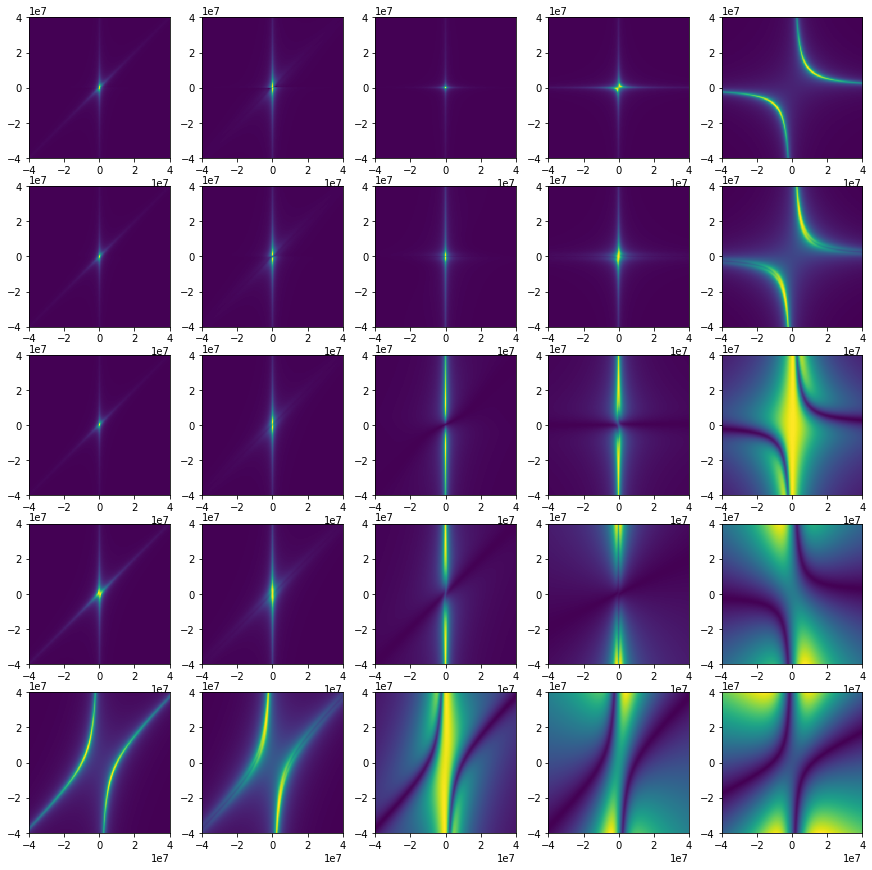

In [205]:
fig=plt.subplots(figsize=(15,15))
plt.rc('text', usetex=False)
pltnum=1
for ii in range(len(omegamvals_test)):
    for jj in range(len(omegaovals_test)):
        sbplt=plt.subplot(len(omegamvals_test), len(omegaovals_test),pltnum)
        pltnum+=1
        sbplt.imshow(np.abs(rho_save[ii,jj,:,:,0,2]),origin='lower',extent=im_lims)


In [196]:
def a_func(del2_lims,del3_lims,*peak_fun):
    if len(peak_fun)!=0:
        S13=N*gval*rho13_integrated(del2_lims, del3_lims,peak_fun[0])
    else:
        S13=N*gval*rho13_integrated_quad(del2_lims,del3_lims)
    return -1j*deltac*aval-1j*S13-kappa/2*aval

In [203]:
def steadya(a_guess,del2_lims,del3_lims,*peak_fun):
    a_steady=scipy.optimize.root(a_func,a_guess,args=(del2_lims,del3_lims,peak_fun))
    if not result.success:
        print(result)
        raise(AssertionError('Nop, no converge '+result.message))
    return a_steady

In [210]:
gval=1.
N=1
deltac=0
kappa=1

steadya(0,[delta2_min,delta2_max],[delta3_min,delta3_max], delta3_mu_func)

TypeError: 'list' object is not callable

In [211]:
a_func([delta2_min,delta2_max],[delta3_min,delta3_max])

In [212]:
aval